**Table of contents**<a id='toc0_'></a>    
- [Using minimize from scipy.optimize](#toc1_1_)    
- [Using PyTorch](#toc2_)    
  - [Chatgpt Trying](#toc2_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
from optic.models.devices import mzm, pm
from scipy.signal import find_peaks
from scipy.constants import c as c0
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

π = np.pi

SpS = 64            # Amostras por símbolo
Rs  = 10e9          # Taxa de símbolos
Ts  = 1/Rs          # Período de símbolo em segundos
Fa  = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta  = 1/Fa          # Período de amostragem

t = np.arange(0, SpS*1000)*Ta

Vπ = 2
Ai = 1
n_peaks = 11


In [5]:
def plot_fb(sigTxo_, n_peaks):
    # plot frequency combs
    
    # plot psd
    plt.figure();
    Pxx, freqs = plt.psd(sigTxo_, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')
    log_Pxx = 10*np.log10(Pxx)
    indx = get_indx_peaks(log_Pxx, n_peaks)
    
    plt.plot(freqs[indx], log_Pxx[indx], 'o')
    plt.legend(loc='lower right');
    #plt.xlim(-16*Rs,16*Rs);
    #plt.ylim(-100,-80);
    
    mean = np.mean(log_Pxx[indx])
    var = np.var(log_Pxx[indx]) 
    plt.plot([freqs[0],freqs[-1]], np.array([1,1])*mean, "--",label = "peaks mean")
    plt.plot([freqs[0],freqs[-1]], np.array([1,1])*(mean+np.sqrt(var)), "--",label = "peaks max")
    plt.plot([freqs[0],freqs[-1]], np.array([1,1])*(mean-np.sqrt(var)), "--",label = "peaks min")
    
    print("Média: %.2f dB" %mean)
    print("Desvio Padrão: %.2f dB" %np.sqrt(var))
    print("Variância: %.2f"%var)
    print("Distância máximo-mínimo: %.2f dB" %(np.max(log_Pxx[indx]) - np.min(log_Pxx[indx])))

In [6]:
def get_indx_peaks(log_Pxx, n_peaks):
    indx = find_peaks(log_Pxx, height=(-150,-50))[0]
    discard = (indx.size - n_peaks)
    indx = indx[int(np.floor(discard/2)): -int(np.ceil(discard/2))]

    return indx

In [7]:
def fb_generator(V1,Phase1,Vb1, V2,Phase2,Vb2, V3,Phase3):
    sigTxo_ = Ai
    sigTxo_ = mzm(sigTxo_, V1 * np.cos(2 * π * Rs * t + Phase1), Vπ, Vb1)
    sigTxo_ =  pm(sigTxo_, V3 * np.cos(2 * π * Rs * t + Phase3), Vπ)
    sigTxo_ = mzm(sigTxo_, V2 * np.cos(2 * π * Rs * t + Phase2), Vπ, Vb2)

    return sigTxo_

In [8]:
def plot_sig_and_fb(sig):

    fig, ax = plt.subplots(2,2,figsize = (20,10));
    ax[0,0].plot(t[:SpS*4]*1e9, sig[:SpS*4].real);
    ax[0,1].plot(t[:SpS*4]*1e9, sig[:SpS*4].imag);
    ax[1,0].plot(t[:SpS*4]*1e9, abs(sig[:SpS*4])**2);
    Pxx, freqs = ax[1,1].psd(sig, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')

    #(freqs, Pxx) =  welch(sig, Fa, nperseg=64*1024)
    log_Pxx = 10*np.log10(Pxx)
    #ax[1,1].plot(freqs, log_Pxx)
    
    indx = get_indx_peaks(log_Pxx, n_peaks)
    
    ax[1,1].plot(freqs[indx], log_Pxx[indx], 'o')
    ax[1,1].legend(loc='lower right');
    #ax[1,1].xlim(-16*Rs,16*Rs);
    #ax[1,1].ylim(-100,-80);
    
    mean = np.mean(log_Pxx[indx])
    var = np.var(log_Pxx[indx])
    ax[1,1].plot([freqs[0],freqs[-1]], np.array([1,1])*mean, "--",label = "peaks mean")
    ax[1,1].plot([freqs[0],freqs[-1]], np.array([1,1])*(mean+np.sqrt(var)), "--",label = "peaks max")
    ax[1,1].plot([freqs[0],freqs[-1]], np.array([1,1])*(mean-np.sqrt(var)), "--",label = "peaks min")
    
    print("Média: %.2f dB" %mean)
    print("Desvio Padrão: %.2f dB" %np.sqrt(var))
    print("Variância: %.2f"%var)
    print("Distância máximo-mínimo: %.2f dB" %(np.max(log_Pxx[indx]) - np.min(log_Pxx[indx])))
    
    ax[0,0].grid()
    ax[0,1].grid()
    ax[1,0].grid()
    #ax[1,1].grid()


Média: -101.90 dB
Desvio Padrão: 10.42 dB
Variância: 108.48
Distância máximo-mínimo: 31.81 dB


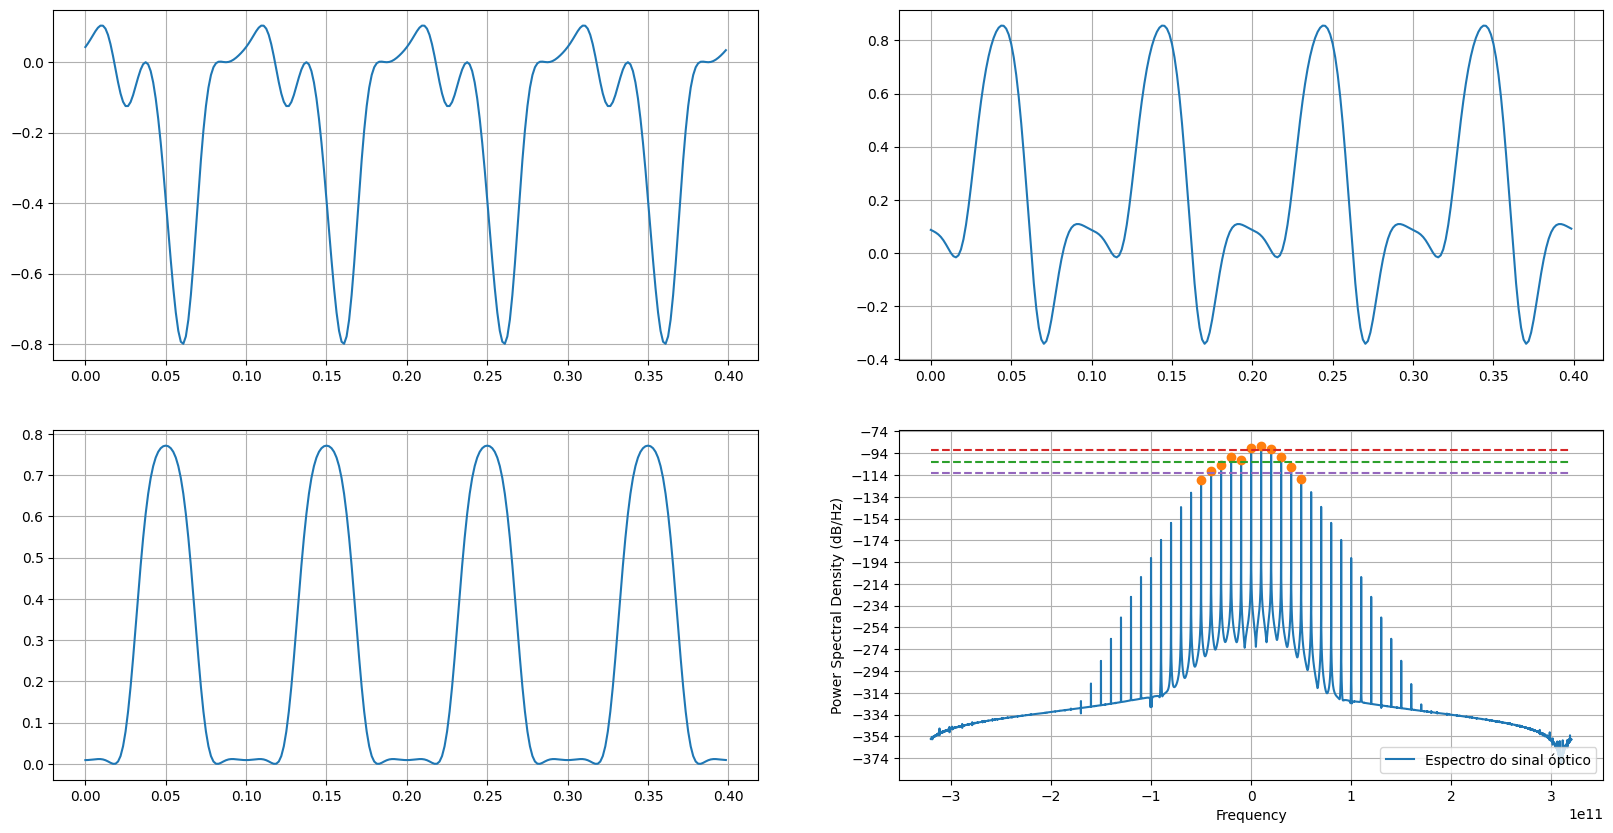

In [9]:
initial_guess = [1, 2*π, π/2, 1, 2*π, 1.5*π, 1, π/4]
sig = fb_generator(*initial_guess)
plot_sig_and_fb(sig)

## <a id='toc1_1_'></a>[Using minimize from scipy.optimize](#toc0_)

In [23]:
from scipy.optimize import minimize

# Função objetivo a ser minimizada
def objective_function(params):
    
    sigTxo_ = fb_generator(*params)
    
    # Calcular a intensidade dos picos e a função objetivo
    #fig = plt.figure()
    #fig.set_visible(False)
    Pxx, _ = plt.psd(sigTxo_, Fs=Fa, NFFT=16 * 1024, sides='twosided')
    #plt.close()
    log_Pxx = 10*np.log10(Pxx)
    indx = get_indx_peaks(log_Pxx, n_peaks)
    
    log_Pxx_peaks = log_Pxx[indx]
    
    intensity = np.mean(log_Pxx_peaks)
    var = np.var(log_Pxx_peaks)
    desvio = np.sqrt(var)
    min_max_dist = np.max(log_Pxx_peaks) - np.min(log_Pxx_peaks)

    target_desvio = 0
    target_var = 0
    target_min_max_dist = 0
    
    # Objetivo: minimizar a diferença entre a intensidade atual e a média desejada
    #return (desvio - target_desvio) ** 2  # Pode usar outras funções de penalização
    return (var - target_var)**2
    #return (min_max_dist - target_min_max_dist)**2

Configurações otimizadas:
V1: 2.83 V
Phase1: 6.08 rad
Vb1: 3.43 V
V2: 2.83 V
Phase2: 6.08 rad
Vb2: 4.57 V
V3: 1.06 V
Phase3: 0.28 rad



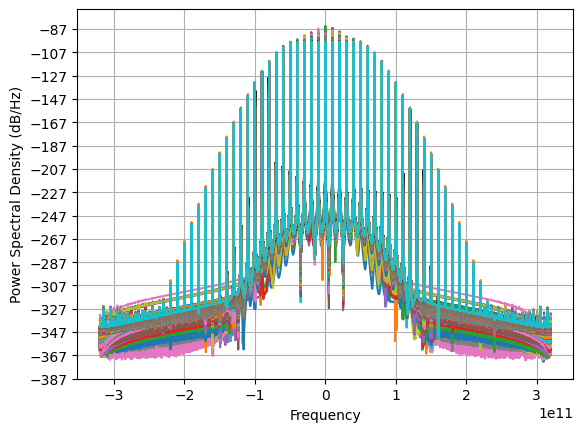

In [24]:
# Chute inicial para as configurações dos moduladores (amplitude e fase)
initial_guess = [1, 2*π, π/2, 1, 2*π, 1.5*π, 1, π/4]

V_min = 0
V_max = 3
Phase_min = 0
Phase_max = 2*π
Vb_min = -4*Vπ
Vb_max = 4*Vπ
bounds = [(V_min,V_max),(Phase_min, Phase_max),(Vb_min,Vb_max),
          (V_min,V_max),(Phase_min, Phase_max),(Vb_min,Vb_max),
          (V_min,V_max),(Phase_min, Phase_max)]

# Realizar a otimização
method = ["Nelder-Mead", "L-BFGS-B", "TNC", "SLSQP", "Powell", "trust-constr", "COBYLA"]
result = minimize(objective_function, initial_guess, method=method[6],bounds = bounds)
optimized_params = result.x

V1, Phase1,  Vb1, V2, Phase2, Vb2, V3, Phase3 = optimized_params

# Exibir as configurações otimizadas
print("Configurações otimizadas:")
print(f"V1: {V1:.2f} V")
print(f"Phase1: {Phase1:.2f} rad")
print(f"Vb1: {Vb1:.2f} V")
print(f"V2: {V2:.2f} V")
print(f"Phase2: {Phase2:.2f} rad")
print(f"Vb2: {Vb2:.2f} V")
print(f"V3: {V3:.2f} V")
print(f"Phase3: {Phase3:.2f} rad\n")

n_peaks = 11
sigTxo_ = fb_generator(*optimized_params)

Média: -98.02 dB
Desvio Padrão: 0.07 dB
Variância: 0.00
Distância máximo-mínimo: 0.21 dB


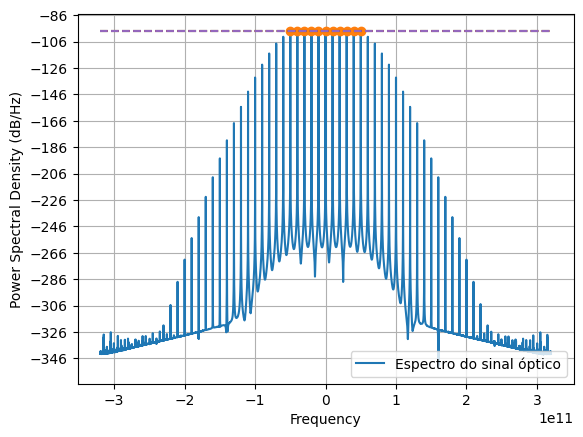

In [25]:
plot_fb(sigTxo_, n_peaks)

Média: -98.02 dB
Desvio Padrão: 0.07 dB
Variância: 0.00
Distância máximo-mínimo: 0.21 dB


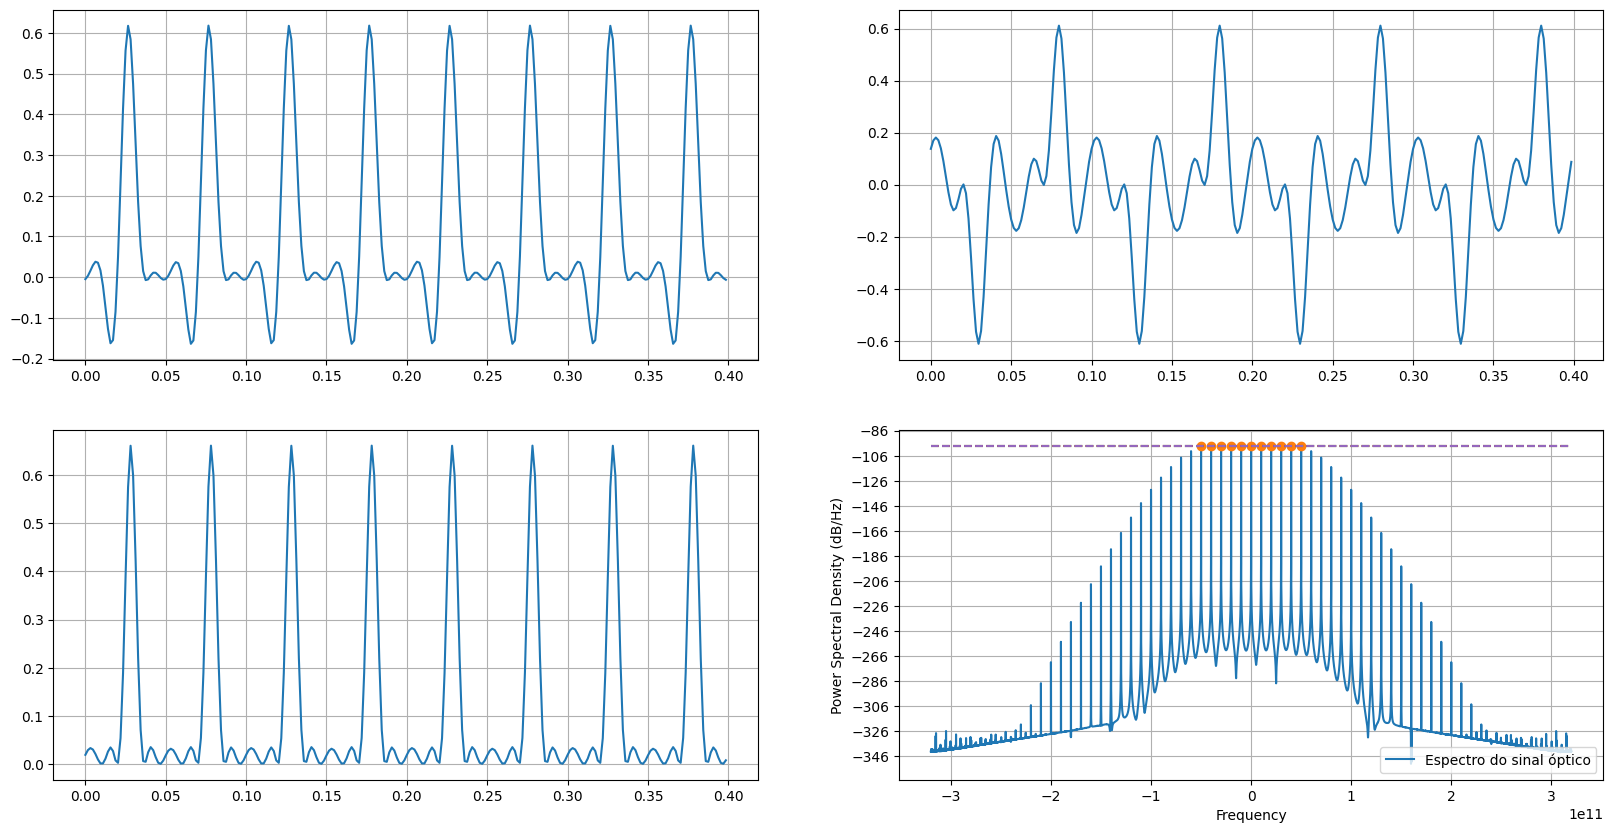

In [26]:
plot_sig_and_fb(sigTxo_)

# <a id='toc2_'></a>[Using PyTorch](#toc0_)

In [4]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.distributions.uniform as urand

In [17]:
class MyNetwork(nn.Module):
  # Inicialização
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(8, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 11)
    )

  # Como a rede computa
  def forward(self, x):
    return self.layers(x)

In [51]:
class AlgebraicDataset(Dataset):
    def __init__(self, f, bounds, nsamples):
        V1 = urand.Uniform(bounds[0][0], bounds[0][1]).sample([nsamples])
        Phase1 = urand.Uniform(bounds[1][0], bounds[1][1]).sample([nsamples])
        Vb1 = urand.Uniform(bounds[2][0], bounds[2][1]).sample([nsamples])

        V2 = urand.Uniform(bounds[3][0], bounds[3][1]).sample([nsamples])
        Phase2 = urand.Uniform(bounds[4][0], bounds[4][1]).sample([nsamples])
        Vb2 = urand.Uniform(bounds[5][0], bounds[5][1]).sample([nsamples])

        V3 = urand.Uniform(bounds[6][0], bounds[6][1]).sample([nsamples])
        Phase3 = urand.Uniform(bounds[7][0], bounds[7][1]).sample([nsamples])

        self.data = []
        for i in range(nsamples):
            V1, Phase1,  Vb1, V2, Phase2, Vb2, V3, Phase3
            self.data.append((V1[i], Phase1[i],  Vb1[i], V2[i], Phase2[i], Vb2[i], V3[i], Phase3[i], 
                         fb_peaks(float(V1[i]), float(Phase1[i]),  float(Vb1[i]), float(V2[i]), float(Phase2[i]), float(Vb2[i]), float(V3[i]), float(Phase3[i]))))

    def __len__(self):
      return len(self.data)

    def __getitem__(self, idx):
      return self.data[idx]

In [52]:
V_min = 0
V_max = 3
Phase_min = 0
Phase_max = 2*π
Vb_min = -4*Vπ
Vb_max = 4*Vπ
bounds = [(V_min,V_max),(Phase_min, Phase_max),(Vb_min,Vb_max),
          (V_min,V_max),(Phase_min, Phase_max),(Vb_min,Vb_max),
          (V_min,V_max),(Phase_min, Phase_max)]

train_nsamples = 1000
test_nsamples = 100

In [53]:
n_peaks = 11
def fb_peaks(V1, Phase1,  Vb1, V2, Phase2, Vb2, V3, Phase3):
    
    #generate the signal (frequency combs)
    fb = fb_generator(V1, Phase1,  Vb1, V2, Phase2, Vb2, V3, Phase3)
    
    # get the signal PSD
    Pxx, _ = plt.psd(fb, Fs=Fa, NFFT=16 * 1024, sides='twosided')
    plt.close()
    log_Pxx = 10*np.log10(Pxx)

    #get n peaks from the signal PSD
    indx = get_indx_peaks(log_Pxx, n_peaks)
    log_Pxx_peaks = log_Pxx[indx]

    return log_Pxx_peaks

In [54]:
train_dataset = AlgebraicDataset(fb_peaks, bounds, train_nsamples)
test_dataset = AlgebraicDataset(fb_peaks, bounds, test_nsamples)

train_dataloader = DataLoader(train_dataset, batch_size=train_nsamples, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=test_nsamples, shuffle=True)

In [67]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

model = MyNetwork().to(device)

# Função de perda (loss function)
lossfunc = nn.MSELoss() # Erro quadrático médio (Mean Squared Error)

# Gradiente Descendente Estocástico - SGD (Stochastic Gradient Descent)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # taxa de aprendizado - lr (learning rate)

Rodando na cpu


In [68]:
def train(model, dataloader, lossfunc, optimizer):
  model.train()
  cumloss = 0.0
  for V1x, Phase1x,  Vb1x, V2x, Phase2x, Vb2x, V3x, Phase3x, y in dataloader:

    V1x = V1x.unsqueeze(1).float().to(device)
    Phase1x = Phase1x.unsqueeze(1).float().to(device)
    Vb1x = Vb1x.unsqueeze(1).float().to(device)
    V2x = V2x.unsqueeze(1).float().to(device)
    Phase2x = Phase2x.unsqueeze(1).float().to(device)
    Vb2x = Vb2x.unsqueeze(1).float().to(device)
    V3x = V3x.unsqueeze(1).float().to(device)
    Phase3x = Phase3x.unsqueeze(1).float().to(device)
    y = y.unsqueeze(1).float().to(device)

    pred = model(V1x, Phase1x,  Vb1x, V2x, Phase2x, Vb2x, V3x, Phase3x)
    loss = lossfunc(pred, y)

    # zera os gradientes acumulados
    optimizer.zero_grad()
    # computa os gradientes
    loss.backward()
    # anda, de fato, na direção que reduz o erro local
    optimizer.step()

    # loss é um tensor; item pra obter o float
    cumloss += loss.item() 
  
  return cumloss / len(dataloader)


def test(model, dataloader, lossfunc):
  model.eval()
  
  cumloss = 0.0
  with torch.no_grad():
    for V1x, Phase1x,  Vb1x, V2x, Phase2x, Vb2x, V3x, Phase3x, y in dataloader:

      V1x = V1x.unsqueeze(1).float().to(device)
      Phase1x = Phase1x.unsqueeze(1).float().to(device)
      Vb1x = Vb1x.unsqueeze(1).float().to(device)
      V2x = V2x.unsqueeze(1).float().to(device)
      Phase2x = Phase2x.unsqueeze(1).float().to(device)
      Vb2x = Vb2x.unsqueeze(1).float().to(device)
      V3x = V3x.unsqueeze(1).float().to(device)
      Phase3x = Phase3x.unsqueeze(1).float().to(device)
      y = y.unsqueeze(1).float().to(device)

      pred = model(V1x, Phase1x,  Vb1x, V2x, Phase2x, Vb2x, V3x, Phase3x)

      loss = lossfunc(pred, y)
      cumloss += loss.item() 
  
  return cumloss / len(dataloader)

In [69]:
# Pra visualizar
def plot_comparinson(f, model, bounds, nsamples=10):
  fig, ax = plt.subplots(figsize=(10, 10))

  #ax.grid(True, which='both')
  #ax.spines['left'].set_position('zero')
  #ax.spines['right'].set_color('none')
  #ax.spines['bottom'].set_position('zero')
  #ax.spines['top'].set_color('none')

  samples = np.linspace(interval[0], interval[1], nsamples)
  model.eval()
  with torch.no_grad():
    pred = model(torch.tensor(samples).unsqueeze(1).float().to(device))

  ax.plot(samples, list(map(f, samples)), "o", label="ground truth")
  ax.plot(samples, pred.cpu(), "s", label="model")
  plt.legend()
  plt.show()

In [ ]:
epochs = 201
for t in range(epochs):
  train_loss = train(model, train_dataloader, lossfunc, optimizer)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
    #plot_comparinson(fb_peaks, model)

test_loss = test(model, test_dataloader, lossfunc)
print(f"Test Loss: {test_loss}")

# <a id='toc2_1_'></a>[Chatgpt Trying](#toc0_)

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

V_min = 0
V_max = 3
Phase_min = 0
Phase_max = 2*π
Vb_min = -4*Vπ
Vb_max = 4*Vπ
bounds = [(V_min,V_max),(Phase_min, Phase_max),(Vb_min,Vb_max),
          (V_min,V_max),(Phase_min, Phase_max),(Vb_min,Vb_max),
          (V_min,V_max),(Phase_min, Phase_max)]

train_nsamples = 1000
test_nsamples = 100
n_peaks = 11

In [9]:
def fb_peaks(V1, Phase1,  Vb1, V2, Phase2, Vb2, V3, Phase3):
    
    #generate the signal (frequency combs)
    fb = fb_generator(V1, Phase1,  Vb1, V2, Phase2, Vb2, V3, Phase3)
    
    # get the signal PSD
    Pxx, _ = plt.psd(fb, Fs=Fa, NFFT=16 * 1024, sides='twosided')
    plt.close()
    log_Pxx = 10*np.log10(Pxx)

    #get n peaks from the signal PSD
    indx = get_indx_peaks(log_Pxx, n_peaks)
    log_Pxx_peaks = log_Pxx[indx]

    return log_Pxx_peaks

In [18]:
V_min = 0.01
V_max = 0.8
Phase = 0
#Phase = 2*π
Vb = -4*Vπ
#Vb = 4*Vπ
for v1 in np.linspace(V_min, V_max, num=10):
    for v2 in np.linspace(V_min, V_max, num=10):
        for v3 in np.linspace(V_min, V_max, num=10):
            peaks = fb_peaks(v1, Phase,  Vb, v2, Phase, Vb, v3, Phase)
            if len(peaks) >= n_peaks:
                print(f"Minimum voltages to get at least {n_peaks} peaks is: {v1:.2f}, {v2:.2f}, {v3:.2f}")
                break

Minimum voltages to get at least 11 peaks is: 0.01, 0.62, 0.80
Minimum voltages to get at least 11 peaks is: 0.01, 0.71, 0.80
Minimum voltages to get at least 11 peaks is: 0.01, 0.80, 0.71
Minimum voltages to get at least 11 peaks is: 0.10, 0.62, 0.80
Minimum voltages to get at least 11 peaks is: 0.10, 0.71, 0.80
Minimum voltages to get at least 11 peaks is: 0.10, 0.80, 0.71
Minimum voltages to get at least 11 peaks is: 0.19, 0.54, 0.80
Minimum voltages to get at least 11 peaks is: 0.19, 0.62, 0.80
Minimum voltages to get at least 11 peaks is: 0.19, 0.71, 0.71
Minimum voltages to get at least 11 peaks is: 0.19, 0.80, 0.71
Minimum voltages to get at least 11 peaks is: 0.27, 0.54, 0.80
Minimum voltages to get at least 11 peaks is: 0.27, 0.62, 0.80
Minimum voltages to get at least 11 peaks is: 0.27, 0.71, 0.71
Minimum voltages to get at least 11 peaks is: 0.27, 0.80, 0.71
Minimum voltages to get at least 11 peaks is: 0.36, 0.45, 0.80
Minimum voltages to get at least 11 peaks is: 0.36, 0.5

In [50]:

# Define your neural network architecture
class FrequencyCombNet(nn.Module):
    def __init__(self, n_peaks):
        super(FrequencyCombNet, self).__init__()
        self.fc1 = nn.Linear(8, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_peaks)

    def forward(self, x, n_peaks):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x[:, :n_peaks]

# Define your custom dataset
class FrequencyCombDataset(Dataset):
    def __init__(self, nsamples, bounds):
        self.nsamples = nsamples
        self.bounds = bounds

    def __len__(self):
        return self.nsamples
    
    def __getitem__(self, idx):
        sample = [urand.Uniform(low, high).sample().item() for low, high in self.bounds]
        output_tensor = torch.tensor(fb_peaks(*sample), dtype=torch.float32)

        # Ensure all 'output' tensors have the same size by padding or truncating
        desired_size = n_peaks  # Change this to the desired size
        if output_tensor.size(0) < desired_size:
            # Padding if the tensor is smaller than desired_size
            padding_size = desired_size - output_tensor.size(0)
            output_tensor = torch.cat([output_tensor, torch.zeros(padding_size)])
        elif output_tensor.size(0) > desired_size:
            # Truncate if the tensor is larger than desired_size
            output_tensor = output_tensor[:desired_size]

        return {'input': torch.tensor(sample, dtype=torch.float32),
                'output': output_tensor}



In [51]:

# Create datasets and dataloaders
train_dataset = FrequencyCombDataset(train_nsamples, bounds)
test_dataset = FrequencyCombDataset(test_nsamples, bounds)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model
model = FrequencyCombNet(n_peaks)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [59]:
def plot_training_progress(train_losses):
    epochs = len(train_losses)

    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.show()

In [60]:

# Training loop
train_losses = []
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    model.train()
    for batch in train_loader:
        inputs, targets = batch['input'], batch['output']
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Save training losses for plotting
    train_losses.append(loss.item())

    # Print training progress
    print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}')


Epoch [1/20], Loss: 1011.4301147460938
Epoch [2/20], Loss: 1087.9747314453125
Epoch [3/20], Loss: 737.9127807617188
Epoch [4/20], Loss: 1053.4810791015625
Epoch [5/20], Loss: 472.0601806640625
Epoch [6/20], Loss: 1457.611572265625
Epoch [7/20], Loss: 705.046142578125
Epoch [8/20], Loss: 486.0313415527344
Epoch [9/20], Loss: 517.3810424804688
Epoch [10/20], Loss: 1217.5546875
Epoch [11/20], Loss: 1337.057861328125
Epoch [12/20], Loss: 975.1727905273438
Epoch [13/20], Loss: 761.8364868164062
Epoch [14/20], Loss: 553.3167724609375
Epoch [15/20], Loss: 1173.506103515625
Epoch [16/20], Loss: 1191.2496337890625


In [ ]:
plot_training_progress(train_losses)

In [56]:

# Testing loop
model.eval()
with torch.no_grad():
    test_loss = 0.0
    for batch in test_loader:
        inputs, targets = batch['input'], batch['output']
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()

    # Print test loss
    print(f'Test Loss: {test_loss / len(test_loader)}')


Test Loss: 711.1364517211914


Test Loss: 0.0


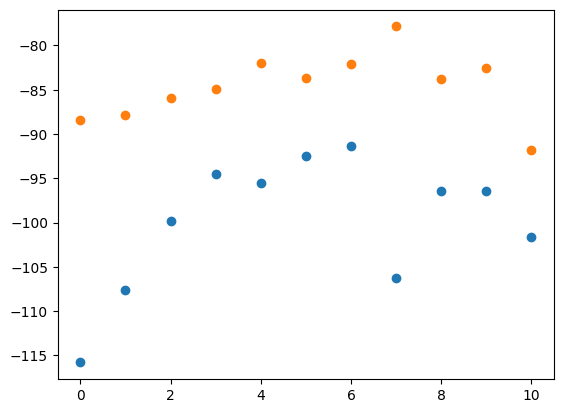

In [58]:
# Testing loop
model.eval()
with torch.no_grad():
    test_loss = 0.0
    for batch in test_loader:
        inputs, targets = batch['input'], batch['output']
        outputs = model(inputs)
        plt.plot(targets[0].numpy(),"o")
        plt.plot(outputs[0].numpy(),"o")
        #test_loss += criterion(outputs, targets).item()

    # Print test loss
    print(f'Test Loss: {test_loss / len(test_loader)}')